In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ase
import pandas as pd
import ase.io as aio

from easydict import EasyDict
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from models.model import MolDiff
from models.bond_predictor import BondPredictor
from utils.sample import seperate_outputs
from utils.transforms import *
from utils.misc import *
from utils.reconstruct import *

In [ ]:
df = pd.read_csv("./fda_approved_drugs.txt", sep="\t")
df = df.query("~smiles.isna()")

In [74]:
penicillin_smiles = df.query("generic_name == 'Penicillin G'")["smiles"].values[0]
penicillin_mol = Chem.MolFromSmiles(penicillin_smiles)
patt = Chem.MolFromSmarts("O=C1CC2N1CCS2")

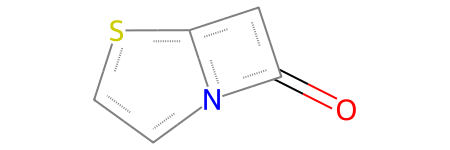

In [75]:
patt

In [77]:
core_ids = penicillin_mol.GetSubstructMatch(patt)

In [56]:
embedding_params = rdDistGeom.ETKDGv3()
mol = Chem.AddHs(penicillin_mol)
rdDistGeom.EmbedMolecule(mol, embedding_params)

0

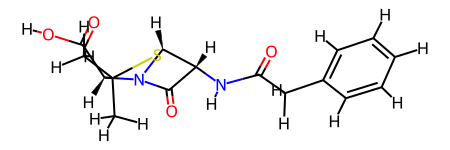

In [57]:
mol

In [58]:
symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
positions = mol.GetConformer().GetPositions()
ase_mol = ase.Atoms(symbols, positions)

In [59]:
aio.write("penicillin.xyz", ase_mol)

In [60]:
ckpt = torch.load("./ckpt/MolDiff.pt", map_location="cuda")

/tmp/ipykernel_1261/3363570379.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./ckpt/MolDiff.pt", map_location="cuda")


In [61]:
train_config = ckpt["config"]
featurizer = FeaturizeMol(train_config.chem.atomic_numbers, train_config.chem.mol_bond_types,
                            use_mask_node=train_config.transform.use_mask_node,
                            use_mask_edge=train_config.transform.use_mask_edge,)

In [62]:
model = MolDiff(
    config=train_config.model,
    num_node_types=featurizer.num_node_types,
    num_edge_types=featurizer.num_edge_types,
).to("cuda")
model.load_state_dict(ckpt["model"])
model.eval()

MolDiff(
  (pos_transition): ContigousTransition()
  (node_transition): GeneralCategoricalTransition()
  (edge_transition): GeneralCategoricalTransition()
  (node_embedder): Linear(in_features=8, out_features=246, bias=False)
  (edge_embedder): Linear(in_features=6, out_features=54, bias=False)
  (time_emb): Sequential(
    (0): GaussianSmearing()
  )
  (denoiser): NodeEdgeNet(
    (distance_expansion): GaussianSmearing()
    (node_blocks_with_edge): ModuleList(
      (0-5): 6 x NodeBlock(
        (node_net): MLP(
          (net): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (2): ReLU()
            (3): Linear(in_features=256, out_features=256, bias=True)
          )
        )
        (edge_net): MLP(
          (net): Sequential(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)


In [63]:
ckpt_bond = torch.load("./ckpt/bondpred.pt", map_location="cuda")
bond_predictor = BondPredictor(ckpt_bond['config']['model'],
        featurizer.num_node_types,
        featurizer.num_edge_types-1 # note: bond_predictor not use edge mask
).to("cuda")
bond_predictor.load_state_dict(ckpt_bond['model'])
bond_predictor.eval()

/tmp/ipykernel_1261/3653359671.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_bond = torch.load("./ckpt/bondpred.pt", map_location="cuda")


BondPredictor(
  (pos_transition): ContigousTransition()
  (node_transition): GeneralCategoricalTransition()
  (node_embedder): Linear(in_features=8, out_features=236, bias=False)
  (edge_embedder): Linear(in_features=16, out_features=44, bias=False)
  (time_emb): GaussianSmearing()
  (encoder): NodeEdgeNet(
    (distance_expansion): GaussianSmearing()
    (node_blocks_with_edge): ModuleList(
      (0-7): 8 x NodeBlock(
        (node_net): MLP(
          (net): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (2): ReLU()
            (3): Linear(in_features=256, out_features=256, bias=True)
          )
        )
        (edge_net): MLP(
          (net): Sequential(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (2): ReLU()
            (3): Linear(in_features=256, out_fe

In [65]:
from simgen.calculators import MaceSimilarityCalculator
from mace.calculators import mace_off
from ase.build import molecule
from pathlib import Path
from ase.optimize import FIRE

In [66]:
calc = mace_off("medium", device="cuda", default_dtype="float32")
z_table = calc.z_table
mace_model = calc.models[0]

Using MACE-OFF23 MODEL for MACECalculator with /home/rokas/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/home/rokas/miniconda3/envs/genesis/lib/python3.11/site-packages/mace/calculators/mace.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc

In [67]:
ase_mol.calc = calc
dyn = FIRE(ase_mol)
dyn.run(fmax=0.05)

      Step     Time          Energy          fmax
FIRE:    0 15:37:34   -38907.175781        9.209658
FIRE:    1 15:37:34   -38908.531250        4.414062
FIRE:    2 15:37:34   -38908.707031        2.663705
FIRE:    3 15:37:35   -38908.871094        1.831516
FIRE:    4 15:37:35   -38908.980469        2.728563
FIRE:    5 15:37:35   -38909.109375        2.626109
FIRE:    6 15:37:35   -38909.269531        1.655919
FIRE:    7 15:37:35   -38909.375000        1.211529
FIRE:    8 15:37:35   -38909.406250        2.302288
FIRE:    9 15:37:36   -38909.421875        2.100570
FIRE:   10 15:37:36   -38909.445312        1.735562
FIRE:   11 15:37:36   -38909.468750        1.285346
FIRE:   12 15:37:36   -38909.492188        1.235374
FIRE:   13 15:37:36   -38909.511719        1.208689
FIRE:   14 15:37:36   -38909.527344        1.203031
FIRE:   15 15:37:36   -38909.546875        1.344923
FIRE:   16 15:37:36   -38909.570312        1.333771
FIRE:   17 15:37:36   -38909.601562        1.136294
FIRE:   18 15:

True

In [68]:
aio.write("penicillin_opt.xyz", ase_mol)

In [78]:
ase_mol = ase_mol[ase_mol.numbers != 1][core_ids]

In [79]:
from ase.visualize import view

In [80]:
view(ase_mol)

<Popen: returncode: None args: ['/home/rokas/miniconda3/envs/genesis/bin/pyt...>

In [ ]:
ref_data_path = Path("~/Programming/data/qm9_no_hydrogens_small.xyz").expanduser()
ref_data = aio.read(ref_data_path, index=":64")

In [143]:
element_sigma_array = np.ones_like(z_table.zs, dtype=np.float32)*0.25
element_sigma_array[z_table.z_to_index(6)] = 0.25
sim_calc = MaceSimilarityCalculator(
    mace_model,
    reference_data=[ase_mol],
    device="cuda",
    alpha=0,
    element_sigma_array=element_sigma_array,
    max_norm=None,
)

In [144]:
batch_holder = make_data_placeholder(n_graphs=12, device="cuda", max_size=12)
batch_node, halfedge_index, batch_halfedge = (
    batch_holder["batch_node"],
    batch_holder["halfedge_index"],
    batch_holder["batch_halfedge"],
)
outputs = model.sample(
    n_graphs=12,
    batch_node=batch_node,
    halfedge_index=halfedge_index,
    batch_halfedge=batch_halfedge,
    bond_predictor=bond_predictor,
    guidance=("simgen", 0.6),
    featurizer=featurizer,
    simgen_calc=sim_calc,
)

100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


In [145]:
outputs = {key:[v.cpu().numpy() for v in value] for key, value in outputs.items()}

In [146]:
batch_node, halfedge_index, batch_halfedge = batch_node.cpu().numpy(), halfedge_index.cpu().numpy(), batch_halfedge.cpu().numpy()
output_list = seperate_outputs(outputs, 12, batch_node, halfedge_index, batch_halfedge)

In [140]:
def traj_to_ase(out, featurizer):
    traj = []
    nodes_to_elements = featurizer.nodetype_to_ele.copy()
    nodes_to_elements[7] = 6
    for nodes, positions, _ in zip(*out):
        numbers = [nodes_to_elements[n] for n in np.argmax(nodes, axis=1)]
        atoms = ase.Atoms(numbers, positions=positions)
        traj.append(atoms)
    return traj

In [147]:
last_frames = [traj_to_ase(out["traj"], featurizer)[-1] for out in output_list]
output_mol = output_list[9]
traj_info = [featurizer.decode_output(
                        pred_node=output_mol['traj'][0][t],
                        pred_pos=output_mol['traj'][1][t],
                        pred_halfedge=output_mol['traj'][2][t],
                        halfedge_index=output_mol['halfedge_index'],
                    ) for t in range(len(output_mol['traj'][0]))]

In [148]:
aio.write("./moldiff_traj.xyz", last_frames)

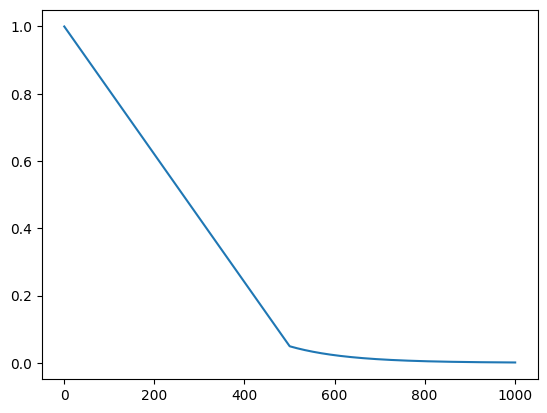

In [128]:
num_steps = 1002
sigmas = (
    torch.concatenate(
        [
            torch.linspace(1, 0.05, num_steps // 2),
            torch.logspace(-1.31, -3, num_steps // 2),
        ]
    )
)
plt.plot(sigmas)

In [ ]:
test_traj = traj_to_ase(output_mol["traj"], featurizer)
forces = []
energy = []
for i, atoms in enumerate(test_traj[::2]):
    atoms.calc = sim_calc
    atoms.info["calculation_type"] = "similarity"
    atoms.info["time"] = sigmas[i].numpy()
    print(atoms.get_potential_energy())
    forces.append(atoms.get_forces())
    energy.append(atoms.get_potential_energy())

In [ ]:
avg_force_mags = [np.linalg.norm(sim_calc._clip_grad_norm(f, np.sqrt(3)),axis=-1).mean(axis=0)*1e-1 for f in forces]
avg_force_mags = [x if x < 10 else 10 for x in avg_force_mags ]

In [ ]:
output_list[0]["traj"][1].shape
diffs = np.diff(output_list[0]["traj"][1], axis=0)
average_diff_mag = np.mean(np.linalg.norm(diffs, axis=-1), axis=1)

In [ ]:
plt.plot(average_diff_mag)
x = np.linspace(0,1000,len(avg_force_mags))
plt.plot(x,avg_force_mags)

In [13]:
import pathlib
import rdkit.Chem as Chem
import numpy as np
import yaml
from rdkit.Chem import rdmolops
import matplotlib.pyplot as plt

In [7]:
results_path = pathlib.Path("./results")
out_mols = {}
out_smiles = {}
# iterate over folders in results_path
for subfolder in results_path.iterdir():
    exp_num = int(subfolder.stem.split("_")[-1])
    with open(subfolder / "SMILES.txt") as f:
        mols = [Chem.MolFromSmiles(line.strip()) for line in f]
        smiles = [line.strip() for line in f]
        out_mols[exp_num] = mols
        out_smiles[exp_num] = smiles

In [12]:
configs = {}
for config in pathlib.Path("./screen_configs").iterdir():
    config_num = int(config.stem.split("_")[-1])
    configs[config_num] = yaml.safe_load(config.read_text())

In [8]:
fragmented_fracs = np.zeros(len(out_mols))
for k, mol_list in out_mols.items():
    num_frags = np.array([len(rdmolops.GetMolFrags(mol, asMols=True)) for mol in mol_list])
    fragmented_fracs[k] = (num_frags > 1).mean()
fragmented_fracs

array([0.99121094, 0.99609375, 0.99902153, 1.        , 0.97947214,
       0.99609375, 1.        , 1.        , 0.07240705, 0.98828125,
       1.        , 0.99511719, 0.99609375, 0.98925781, 0.94921875,
       0.99316406, 0.9921875 , 1.        , 1.        , 0.94042969,
       0.9921875 , 1.        , 0.98046875, 0.99804688, 0.453125  ,
       1.        , 1.        , 0.99609375, 0.99804688, 0.8984375 ,
       0.00685602, 1.        , 0.99414062, 0.99707031, 0.44281525,
       0.98729228, 1.        , 0.99609375, 0.99511719, 0.99414062,
       1.        , 0.95117188, 1.        , 0.99707031, 0.99121094,
       0.99804688, 0.97949219, 0.93450635, 0.99414062, 0.99414062])

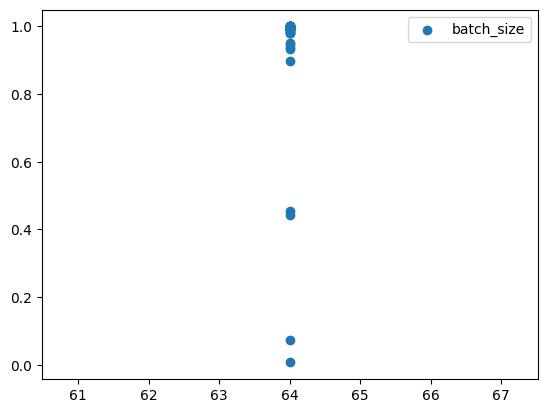

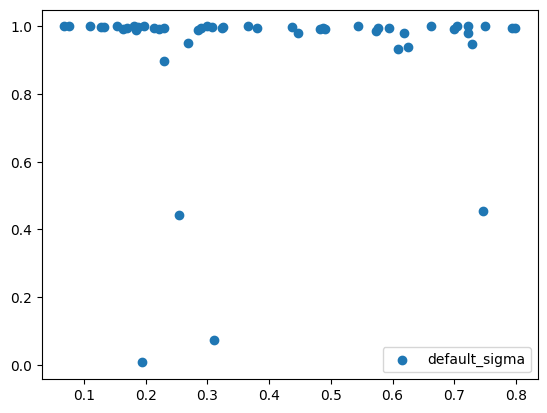

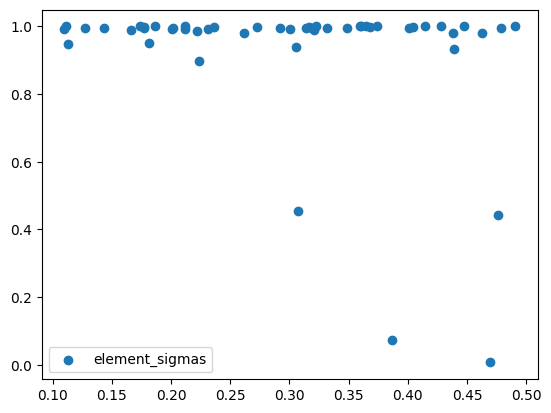

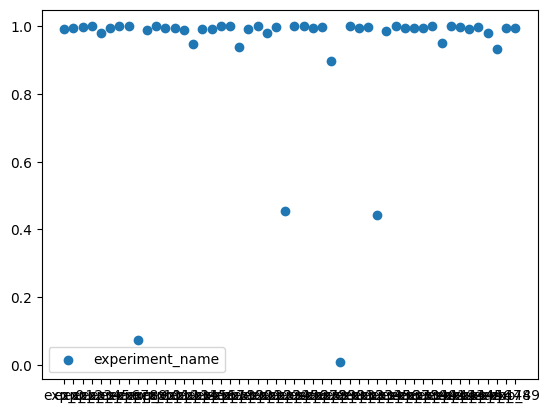

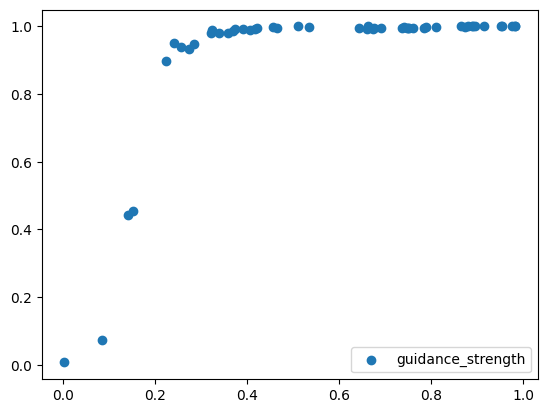

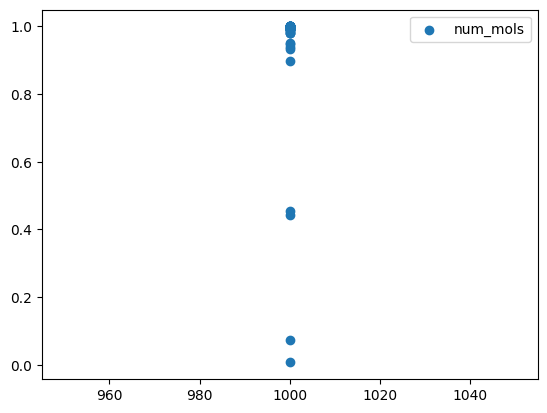

In [20]:
# iterate over screened params and plot param value vs fragmented fraction
config_example = configs[0]
for param in config_example.keys():
    if param != "element_sigmas":
        xs = [configs[i][param] for i in range(len(configs))]
    else:
        xs = [configs[i][param][7] for i in range(len(configs))]
    plt.scatter(xs, fragmented_fracs, label=param)
    plt.legend()
    plt.show()